## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Predict housing prices to be used by PE shop looking to make purchases.

In [2]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm #remove error warning

%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# import dataset

data = pd.read_csv('kc_house_data.csv')

In [4]:
# look at dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# look at price to get a sense of what we want to predict and its distribution, etc.
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

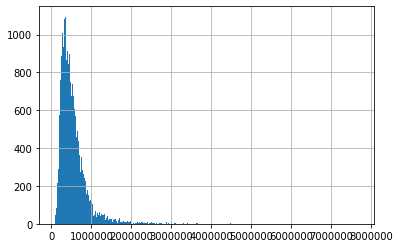

In [6]:
data['price'].hist(bins='auto')

In [7]:
# how many entries have a price greater than 1M
data.loc[data['price'] > 1000000]['price'].count()

1458

In [8]:
# Check 3 standard deviation cutoff for housing limit
three_stds = data['price'].std() * 3
three_stds

1102104.4203041834

In [9]:
# high point
high_point = data['price'].median() + three_stds
round(high_point, 2)

1552104.42

In [10]:
# remove all houses with prices greater than the identified high point
houses_data = data.loc[data['price'] <= high_point]

In [11]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21114 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21114 non-null  int64  
 1   date           21114 non-null  object 
 2   price          21114 non-null  float64
 3   bedrooms       21114 non-null  int64  
 4   bathrooms      21114 non-null  float64
 5   sqft_living    21114 non-null  int64  
 6   sqft_lot       21114 non-null  int64  
 7   floors         21114 non-null  float64
 8   waterfront     18786 non-null  float64
 9   view           21053 non-null  float64
 10  condition      21114 non-null  int64  
 11  grade          21114 non-null  int64  
 12  sqft_above     21114 non-null  int64  
 13  sqft_basement  21114 non-null  object 
 14  yr_built       21114 non-null  int64  
 15  yr_renovated   17360 non-null  float64
 16  zipcode        21114 non-null  int64  
 17  lat            21114 non-null  float64
 18  long  

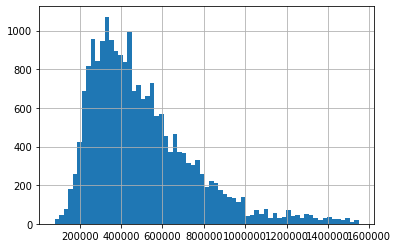

In [12]:
# look at the histogram
houses_data['price'].hist(bins='auto')

In [13]:
houses_data['price'].describe()

count    2.111400e+04
mean     5.030432e+05
std      2.514620e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.450000e+05
75%      6.250000e+05
max      1.550000e+06
Name: price, dtype: float64

The median house price is still relatively inline with where it was before removing the upper set of houses

In [14]:
houses_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [15]:
# remove ID column as it is not relevant
houses_data = houses_data.drop(columns='id')

In [16]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [17]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21114 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21114 non-null  object 
 1   price          21114 non-null  float64
 2   bedrooms       21114 non-null  int64  
 3   bathrooms      21114 non-null  float64
 4   sqft_living    21114 non-null  int64  
 5   sqft_lot       21114 non-null  int64  
 6   floors         21114 non-null  float64
 7   waterfront     18786 non-null  float64
 8   view           21053 non-null  float64
 9   condition      21114 non-null  int64  
 10  grade          21114 non-null  int64  
 11  sqft_above     21114 non-null  int64  
 12  sqft_basement  21114 non-null  object 
 13  yr_built       21114 non-null  int64  
 14  yr_renovated   17360 non-null  float64
 15  zipcode        21114 non-null  int64  
 16  lat            21114 non-null  float64
 17  long           21114 non-null  float64
 18  sqft_l

In [18]:
# handle missing values - - view, waterfront, yr_renovated are the only columns missing values
houses_data['waterfront'].nunique()

2

In [19]:
houses_data['waterfront'].unique()

array([nan,  0.,  1.])

In [20]:
# check how many are missing
houses_data['waterfront'].isna().sum()

2328

In [21]:
# 11% of the data is NaN, don't want to drop this many rows - - set all NaNs as 0

In [22]:
# assuming that NaNs in the waterfront column are related to houses that do not have waterfront
# will relabel all NaNs as 0
houses_data['waterfront'] = houses_data['waterfront'].fillna(value=0.)

In [23]:
# check there are no more missing values
houses_data['waterfront'].isna().any()

False

In [24]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21114 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21114 non-null  object 
 1   price          21114 non-null  float64
 2   bedrooms       21114 non-null  int64  
 3   bathrooms      21114 non-null  float64
 4   sqft_living    21114 non-null  int64  
 5   sqft_lot       21114 non-null  int64  
 6   floors         21114 non-null  float64
 7   waterfront     21114 non-null  float64
 8   view           21053 non-null  float64
 9   condition      21114 non-null  int64  
 10  grade          21114 non-null  int64  
 11  sqft_above     21114 non-null  int64  
 12  sqft_basement  21114 non-null  object 
 13  yr_built       21114 non-null  int64  
 14  yr_renovated   17360 non-null  float64
 15  zipcode        21114 non-null  int64  
 16  lat            21114 non-null  float64
 17  long           21114 non-null  float64
 18  sqft_l

In [25]:
# look at yr_renovated
houses_data['yr_renovated'].nunique()

70

In [26]:
houses_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1998., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [27]:
# fill NaNs with 0. -- assuming these did not receive a reno
houses_data['yr_renovated'] = houses_data['yr_renovated'].fillna(value=0.)

In [28]:
# should be no more missing values
houses_data.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view              True
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [29]:
# view is missing some values - - how many are missing?
houses_data['view'].isna().sum()

61

In [30]:
# only 61 are missing - - remove all entries without view
houses_data['view'].unique()

array([ 0., nan,  3.,  2.,  4.,  1.])

In [31]:
houses_data = houses_data.dropna()

In [32]:
houses_data.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [33]:
# no more missing values - - check for duplicates
houses_data.duplicated().any()

False

In [34]:
# no duplicates

In [35]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21053 non-null  object 
 1   price          21053 non-null  float64
 2   bedrooms       21053 non-null  int64  
 3   bathrooms      21053 non-null  float64
 4   sqft_living    21053 non-null  int64  
 5   sqft_lot       21053 non-null  int64  
 6   floors         21053 non-null  float64
 7   waterfront     21053 non-null  float64
 8   view           21053 non-null  float64
 9   condition      21053 non-null  int64  
 10  grade          21053 non-null  int64  
 11  sqft_above     21053 non-null  int64  
 12  sqft_basement  21053 non-null  object 
 13  yr_built       21053 non-null  int64  
 14  yr_renovated   21053 non-null  float64
 15  zipcode        21053 non-null  int64  
 16  lat            21053 non-null  float64
 17  long           21053 non-null  float64
 18  sqft_l

In [36]:
# handle strings - - convert to appropriate types
houses_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '700.0', '820.0', '780.0', '790.0', '330.0',
       '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0', '600.0',
       '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0', '880.0',
       '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0', '840.0',
       '380.0', '770.0', '480.0', '570.0', '1490.0', '620.0', '1250.0',
       '1270.0', '120.0', '650.0', '180.0', '1130.0', '450.0', '1460.0',
       '1020.0', '1030.0', '750.0', '640.0', '1070.0', '490.0', '1310.0',
       '630.0', '2000.0', '390.0', '430.0', '210.0', '1430.0', '1950.0',
       '440.0', '220.0', '1160.0', '860.0', '580.0', '2060.0', '1180.0',
       '200.0', '1150.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0',
       '960.0', '870.0', '280.0', '1200.0', '1100.0', '460.0', '1400.0',
       '720.0', '660.0', '1220.0', '900.0', '420.0', '1580.0', '1380.0',
       '475.0', '690.0', '270.0', '350.0', '935.0', '7

In [37]:
# need to remove the entries with ?
# check how many there are
houses_data.loc[houses_data['sqft_basement'] == '?']['price'].count()

446

In [38]:
# only 446 entries out of ~20,000 - - remove these
houses_data = houses_data.loc[houses_data['sqft_basement'] != '?']

In [39]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20607 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20607 non-null  object 
 1   price          20607 non-null  float64
 2   bedrooms       20607 non-null  int64  
 3   bathrooms      20607 non-null  float64
 4   sqft_living    20607 non-null  int64  
 5   sqft_lot       20607 non-null  int64  
 6   floors         20607 non-null  float64
 7   waterfront     20607 non-null  float64
 8   view           20607 non-null  float64
 9   condition      20607 non-null  int64  
 10  grade          20607 non-null  int64  
 11  sqft_above     20607 non-null  int64  
 12  sqft_basement  20607 non-null  object 
 13  yr_built       20607 non-null  int64  
 14  yr_renovated   20607 non-null  float64
 15  zipcode        20607 non-null  int64  
 16  lat            20607 non-null  float64
 17  long           20607 non-null  float64
 18  sqft_l

In [40]:
# now need to convert basement column to a number format
houses_data['sqft_basement'] = houses_data['sqft_basement'].astype('float64')

In [41]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20607 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20607 non-null  object 
 1   price          20607 non-null  float64
 2   bedrooms       20607 non-null  int64  
 3   bathrooms      20607 non-null  float64
 4   sqft_living    20607 non-null  int64  
 5   sqft_lot       20607 non-null  int64  
 6   floors         20607 non-null  float64
 7   waterfront     20607 non-null  float64
 8   view           20607 non-null  float64
 9   condition      20607 non-null  int64  
 10  grade          20607 non-null  int64  
 11  sqft_above     20607 non-null  int64  
 12  sqft_basement  20607 non-null  float64
 13  yr_built       20607 non-null  int64  
 14  yr_renovated   20607 non-null  float64
 15  zipcode        20607 non-null  int64  
 16  lat            20607 non-null  float64
 17  long           20607 non-null  float64
 18  sqft_l

In [42]:
"""
Function to plot y vs. a chosen set of x variables
"""

def plot_x_y(x_vals, y_val):
    fig, axes = plt.subplots(nrows = 1, ncols=len(x_vals), figsize=(20,5))
    for xcol, ax in zip(x_vals, axes):
        houses_data.plot(kind='scatter', x=xcol, y=y_val, ax=ax, alpha=0.5)
    plt.tight_layout()
    plt.show()

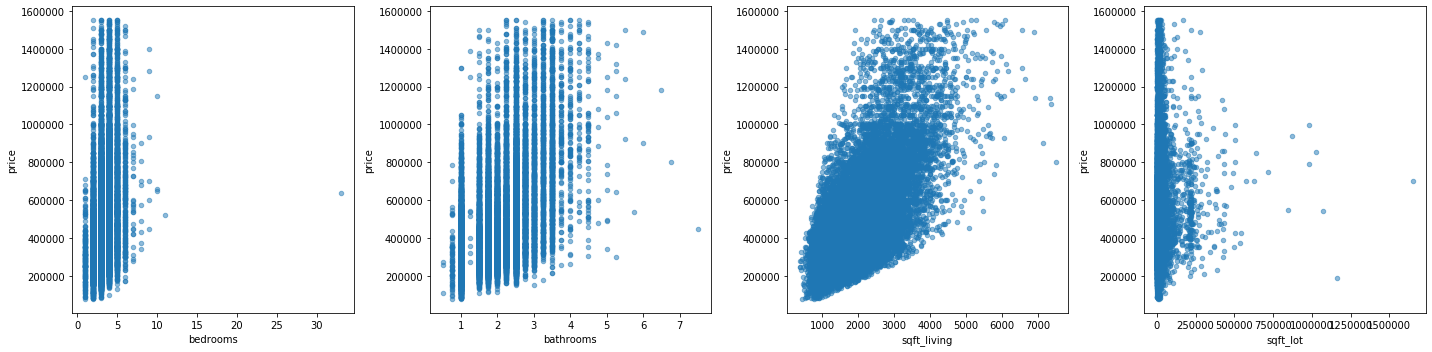

In [43]:
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

In [44]:
# deal with outliers -- there are som significant outliers seen, specifically in bedrooms and sqft_lot

houses_data.loc[houses_data['bedrooms'] >= 7]['price'].count()

50

In [45]:
# only 290 entries have bedrooms greater than 7 - - remove these
houses_data = houses_data.loc[houses_data['bedrooms'] < 7]

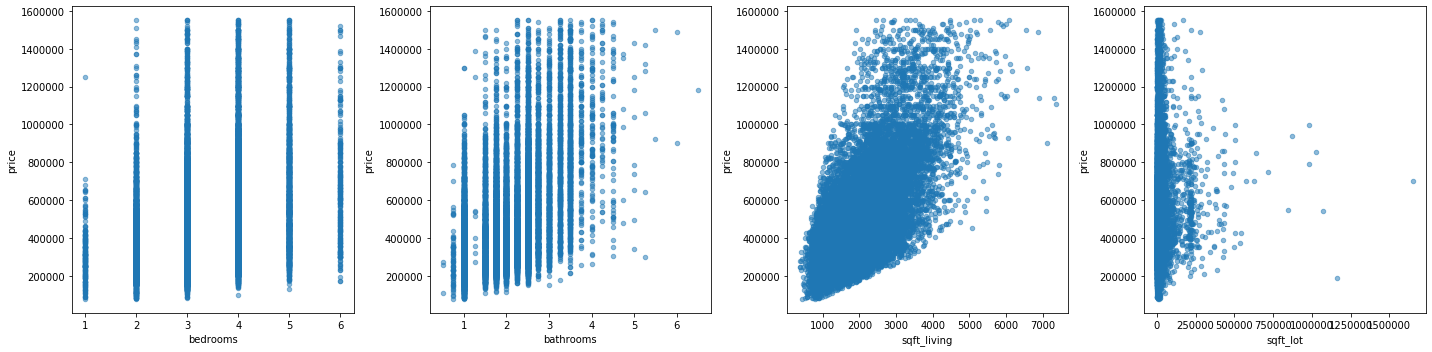

In [46]:
# replot
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

In [47]:
# how many total entries do we have left?
len(houses_data)

20557

In [48]:
# distributions are looking much better now - - there are still some funky data points within sqft_lot
houses_data['sqft_lot'].describe()

count    2.055700e+04
mean     1.476555e+04
std      4.013215e+04
min      5.200000e+02
25%      5.002000e+03
50%      7.560000e+03
75%      1.046000e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [49]:
# how many houses have more than 50k sqft lot
houses_data.loc[houses_data['sqft_lot'] > 50000]['price'].count()

824

In [50]:
# only a small number - - going to remove these entries
houses_data = houses_data.loc[houses_data['sqft_lot'] <= 50000]

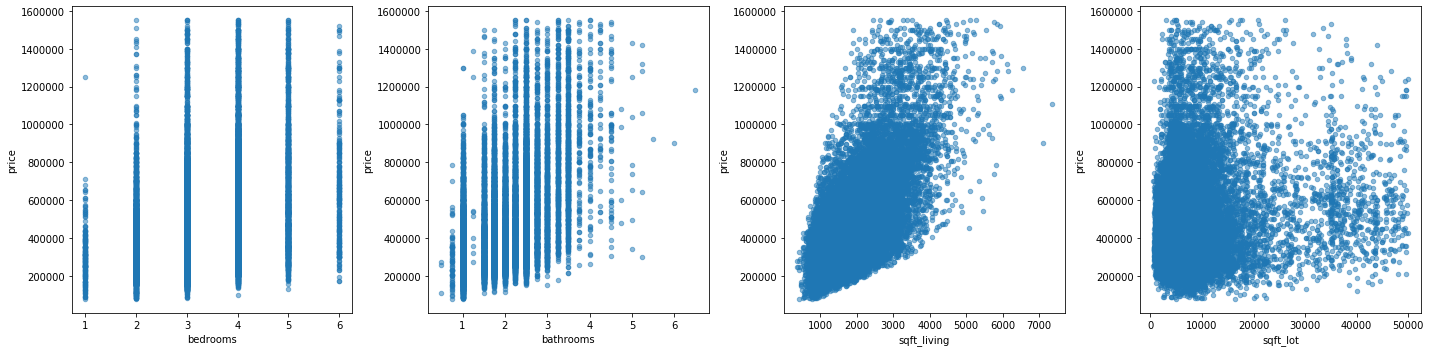

In [51]:
# replot
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

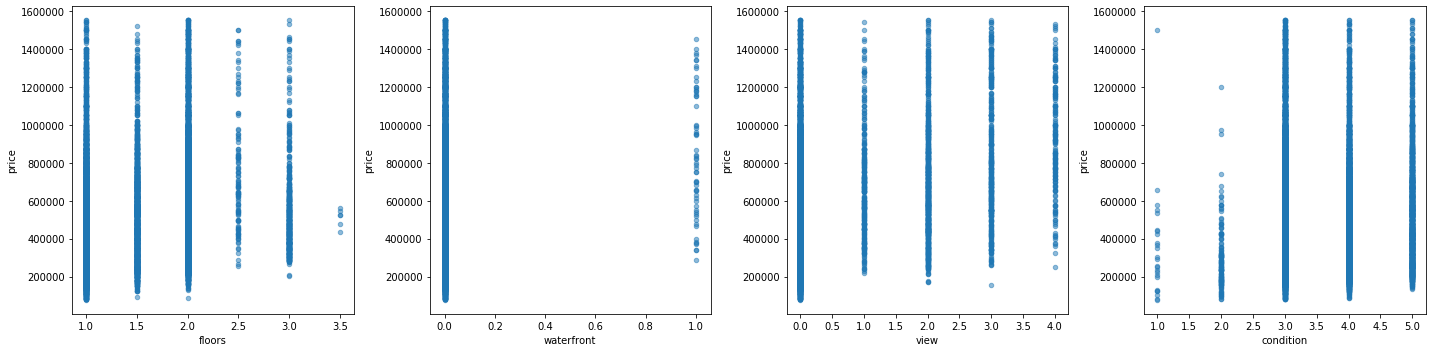

In [52]:
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price')

In [53]:
# check how many entries have more than 3 floors

houses_data.loc[houses_data['floors'] > 3]['price'].count()


6

In [54]:
# given there are only 6, remove these
houses_data = houses_data.loc[houses_data['floors'] <= 3]

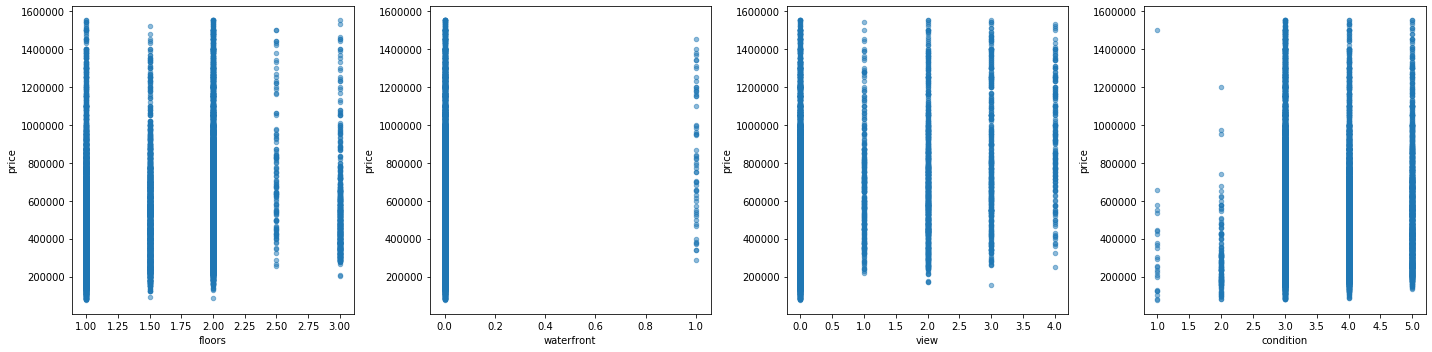

In [55]:
# replot
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price')

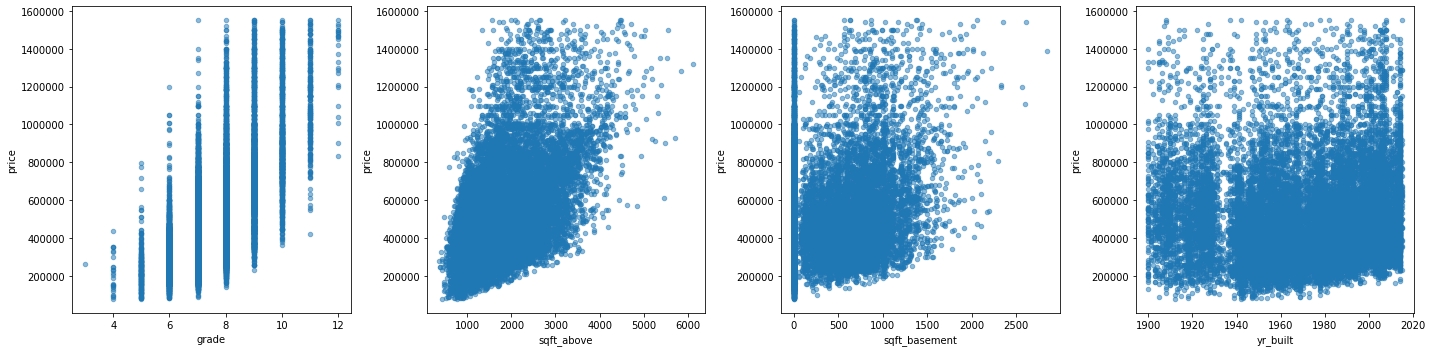

In [56]:
plot_x_y(['grade', 'sqft_above', 'sqft_basement', 'yr_built'], 'price')

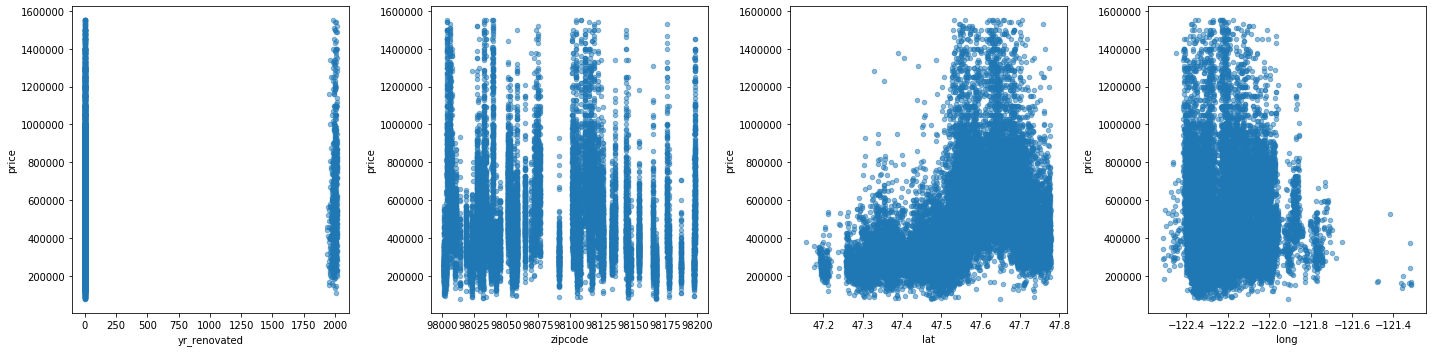

In [57]:
plot_x_y(['yr_renovated', 'zipcode', 'lat', 'long'], 'price')

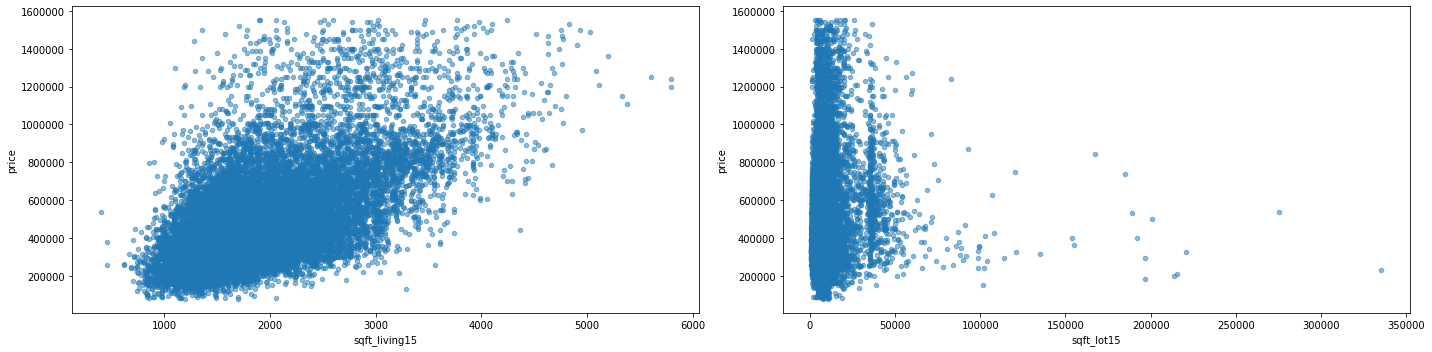

In [58]:
plot_x_y(['sqft_living15', 'sqft_lot15'], 'price')

In [59]:
# clear continuouse variables from these plots appear to be sqft_living, sqft_lot, sqft_above, sqft_basement,
# lat, and long - - it also seems like there may be some polynomial relationship between lat and price
cont_variables = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long']

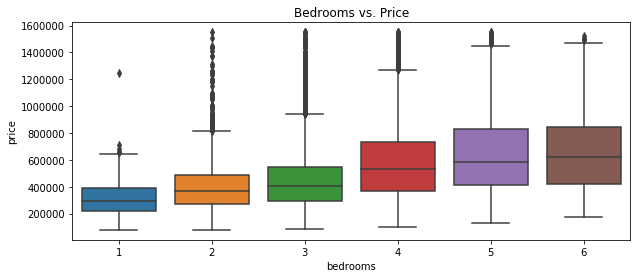

In [60]:
# evaluate other columns for ordinal relationships - if ordinal, will treat as a single column, otherwise 
# create dummy vars
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bedrooms', y='price', data=houses_data)
ax.set_title('Bedrooms vs. Price')
plt.show()

In [61]:
# there is a clear ordinal relationship between the number of bedrooms and price - - will leave as a single feature

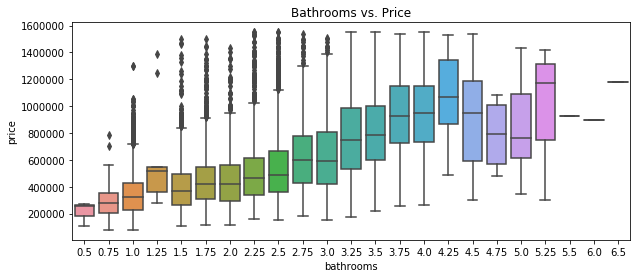

In [62]:
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bathrooms', y='price', data=houses_data)
plt.title('Bathrooms vs. Price')
plt.show()

In [63]:
# how many entries have more than 5 bathrooms?
houses_data.loc[houses_data['bathrooms'] > 5]['price'].count()

9

In [64]:
# there are only 106 entries with more than 4 bathrooms - - cutoff at 4 bathrooms
houses_data = houses_data.loc[houses_data['bathrooms'] <= 5]

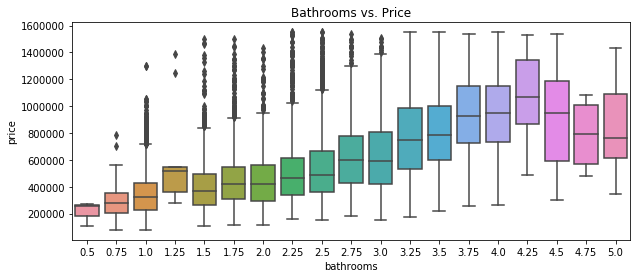

In [65]:
# replot
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bathrooms', y='price', data=houses_data)
plt.title('Bathrooms vs. Price')
plt.show()

In [66]:
# again there appears to be an ordinal relationship between the number of bathrooms and bedrooms

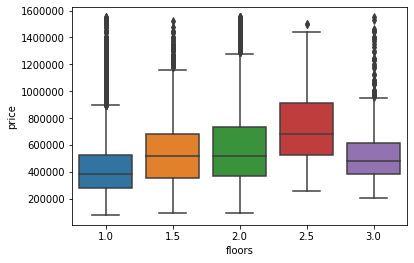

In [67]:
ax = sns.boxplot(x='floors', y='price', data=houses_data)

In [68]:
# there appears to be an ordinal relationship here

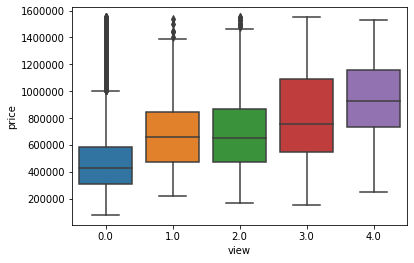

In [69]:
ax = sns.boxplot(x='view', y='price', data=houses_data)

In [70]:
# clear ordinal relationship here

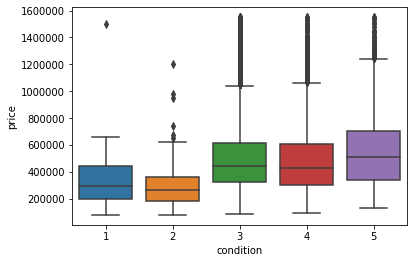

In [71]:
ax = sns.boxplot(x='condition', y='price', data=houses_data)

In [72]:
# ordinal 

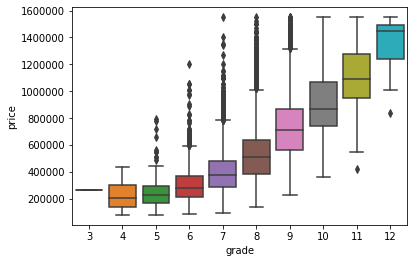

In [73]:
ax = sns.boxplot(x='grade', y='price', data=houses_data)

In [74]:
# there appears to be an ordinal relationship here - - potentially exponential?

In [75]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [76]:
# check for multicollinearity and remove where necessary
data_pred = houses_data.iloc[:, 2:]
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [77]:
abs(data_pred.corr()) > 0.75

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
sqft_above,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [78]:
# return only highly correlated pairs
# save absolute value of correlation matrix as data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

#zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

#set index to pairs
df.set_index(['pairs'], inplace=True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)


In [79]:
# get pairs that are more than 75% correlated
df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.855493
"(sqft_living15, sqft_living)",0.756622


In [80]:
# remove sqft_living as that appears correlated with both sqft_above and sqft_living15

In [81]:
houses_data = houses_data.drop(['sqft_living'], axis=1)

In [82]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [83]:
# categorical columns prior to any preprocessing
cat_origin = houses_data[['waterfront']]
ordinal_cat = houses_data[['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']]

In [84]:
cat_origin.head()

,waterfront
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [85]:
ordinal_cat.head()

,bedrooms,bathrooms,floors,view,condition,grade
0,3,1.00,1.0,0.0,3,7
1,3,2.25,2.0,0.0,3,7
2,2,1.00,1.0,0.0,3,6
3,4,3.00,1.0,0.0,5,7
4,3,2.00,1.0,0.0,3,8


In [86]:
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)

In [87]:
# columns that meet linearity requirement
linearity_req = ['sqft_above', 'sqft_basement', 'bedrooms', 'bathrooms', 
                 'floors', 'view', 'condition', 'grade', 'sqft_living15']

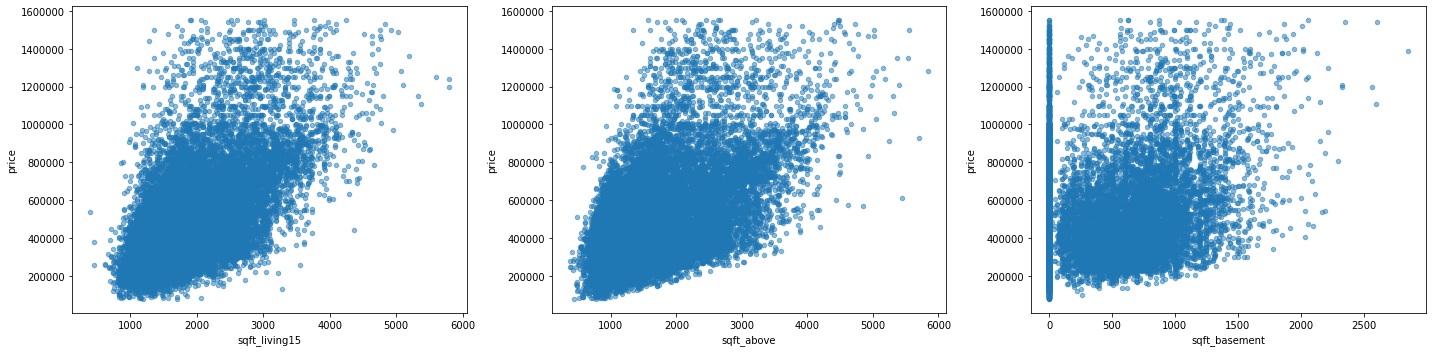

In [88]:
# plot all cont linear columns against price
plot_x_y(['sqft_living15', 'sqft_above', 'sqft_basement'], 'price')

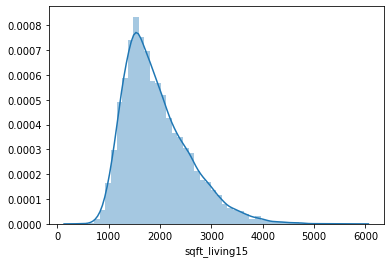

In [89]:
# log transform non-normal
sns.distplot(houses_data['sqft_living15'])

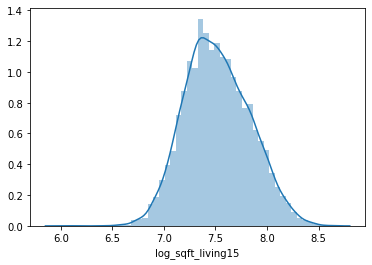

In [90]:
# this would likley benefit from log transformation
houses_data['log_sqft_living15'] = np.log(houses_data['sqft_living15'])
sns.distplot(houses_data['log_sqft_living15'])

In [91]:
# looking more normal
# drop sqft_living15
houses_data = houses_data.drop(['sqft_living15'], axis=1)

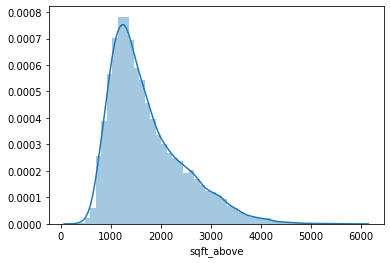

In [92]:
sns.distplot(houses_data['sqft_above'])

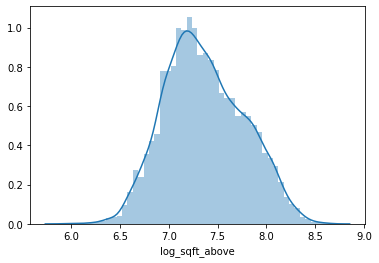

In [93]:
# log transform
houses_data['log_sqft_above'] = np.log(houses_data['sqft_above'])
sns.distplot(houses_data['log_sqft_above'])

In [94]:
houses_data = houses_data.drop(['sqft_above'], axis=1)

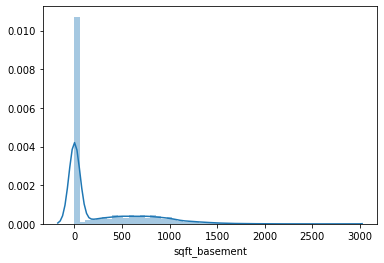

In [95]:
sns.distplot(houses_data['sqft_basement'])

In [96]:
# going to leave this one as it is
preprocessed = pd.concat([houses_data, water_dummies], axis=1)

In [97]:
preprocessed = preprocessed.drop(['waterfront', 'date'], axis=1)

In [98]:
y = preprocessed['price']
X = preprocessed.drop(['price'], axis=1)

In [99]:
import statsmodels.api as sm
predictors_int = sm.add_constant(X)

In [100]:
model = sm.OLS(preprocessed['price'], predictors_int).fit()

In [101]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2751.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:58:10   Log-Likelihood:            -2.6106e+05
No. Observations:               19718   AIC:                         5.222e+05
Df Residuals:                   19700   BIC:                         5.223e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.456e+06   2.09e+06     -0.697      0.486   -5.55e+06    2.64e+06
bedrooms          -1.399e+04   1510.336     -9.261      0.000   -1.69e+04    -1.1e+04
bathrooms          2.962e+04   2399.816     12.341      0.000    2.49e+04    3.43e+04
sqft_lot             -1.3246      0.201     -6.592      0.000      -1.718      -0.931
floors             2.794e+04   2682.368     10.414      0.000    2.27e+04    3.32e+04
view               4.377e+04   1597.519     27.396      0.000    4.06e+04    4.69e+04
condition          2.547e+04   1664.298     15.302      0.000    2.22e+04    2.87e+04
grade              9.664e+04   1533.178     63.033      0.000    9.36e+04    9.96e+04
sqft_basement        81.8752      3.302     24.799      0.000      75.404      88.347
yr_built          -2288.1758     51.247    -44.650      0.000   -2388.623   -2187.728
yr_renovated         19.6020      2.905      6.748      0.000      13.908      25.296
zipcode            -306.7918     23.254    -13.193      0.000    -352.371    -261.212
lat                5.671e+05   7623.086     74.398      0.000    5.52e+05    5.82e+05
long              -5.664e+04   9586.638     -5.908      0.000   -7.54e+04   -3.78e+04
sqft_lot15           -0.2414      0.149     -1.621      0.105      -0.533       0.051
log_sqft_living15  9.381e+04   5056.380     18.553      0.000    8.39e+04    1.04e+05
log_sqft_above     1.436e+05   5259.264     27.306      0.000    1.33e+05    1.54e+05
water_1.0          1.893e+05   1.84e+04     10.289      0.000    1.53e+05    2.25e+05
==============================================================================
Omnibus:                     3922.696   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12496.283
Skew:                           1.015   Prob(JB):                         0.00
Kurtosis:                       6.330   Cond. No.                     2.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
# use feature selection now to select significant values